# Neural Networks in Dressed quantum circuits for NLP

In [1]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import nltk
import torch

from discopy import grammar
from pytket.circuit.display import render_circuit_jupyter

#from lambeq.ccg2discocat import DepCCGParser
from lambeq import BobcatParser
from lambeq.ansatz.circuit import IQPAnsatz
from lambeq.core.types import AtomicType

N = AtomicType.NOUN
S = AtomicType.SENTENCE

from sympy import default_sort_key

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit, IBMQBackend
from pytket.qasm import circuit_to_qasm_str

from sympy import default_sort_key

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit, IBMQBackend

from pytket.qasm import circuit_to_qasm_str

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

/Users/cdunne/ICHEC/git_repos/WP6_QNLP/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-05 19:01:45.477041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Getting BERT Embeddings

In this section we retrieve word embedding from a pretrained model. WE are using a BERT model with 768-dimensional context dependant vectors for each word.
The embeddings are selected as the outputs from the last layers of the model. More investigation is needed to determine which is the best layer to retrieve these vectors from, and how it affects the transfer learning approach.

In [2]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,
                                  )

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
def bert_text_preparation(text, tokenizer):

    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    del_list = []
    for i,x in enumerate(tokenized_text):
        if x[0]=='#':
            tokenized_text[i] = tokenized_text[i-1] + tokenized_text[i][2:]
            del_list.append(i-1)
    tokenized_text = [tokenized_text[i] for i in range(len(tokenized_text)) if i not in del_list]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)


    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors
    
def get_bert_embeddings(tokens_tensor, segments_tensors, model):


    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)

        hidden_states = outputs[2][1:]


    token_embeddings = hidden_states[-1]

    token_embeddings = torch.squeeze(token_embeddings, dim=0)

    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

In [4]:
def get_sentence_BERT_embeddings(SenList):
    Sentences_Embeddings = []
    if type(SenList) == str:
        SenList = [SenList]
    for sentence in SenList:
        tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, tokenizer)
        list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
        nwords = len(sentence.split(" "))

        word_embeddings = []
        for word in sentence.split(" "):
            word_index = tokenized_text.index(word.lower().replace(".",""))
            word_embeddings.append(list_token_embeddings[word_index])

        Sentences_Embeddings.append(word_embeddings)
    return Sentences_Embeddings

In [5]:
example_sentence= "Alice repairs the car"
example_sentence_embedding = get_sentence_BERT_embeddings("Alice repairs the car")
print(example_sentence)
print("Number of words: ", len(example_sentence_embedding[0]))
print("Parameters per word: ", [len(embedding) for embedding in example_sentence_embedding[0]])

Alice repairs the car
Number of words:  4
Parameters per word:  [768, 768, 768, 768]


## DisCoCat Circuits

In this section the DisCoCat diagrams and the corresponding quantum circuits are created. The Ansatz used is the Instantaneous Quantum Polynomial (IQP), with a first layer consisting of Hadamard gates and a second layer made up of parametrized diagonal one- and two-qubit gates. 

Tensorial methods implemented by the Lambeq library are used to rewrite the circuits in order to reduce the number of qubits required. 

In [6]:
from discopy import grammar
from pytket.circuit.display import render_circuit_jupyter

#from lambeq.ccg2discocat import DepCCGParser
from lambeq import BobcatParser
from lambeq.ansatz.circuit import IQPAnsatz
from lambeq.core.types import AtomicType

N = AtomicType.NOUN
S = AtomicType.SENTENCE

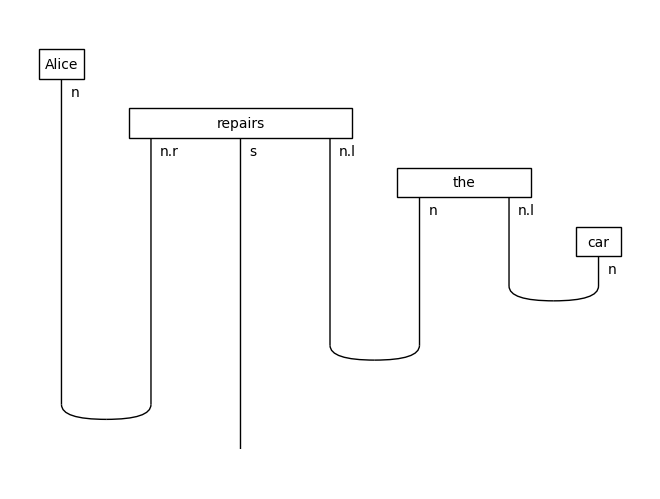

In [7]:
#depccg_parser = DepCCGParser()
#diagram = depccg_parser.sentence2diagram('Alice repairs the car')
#diagram.draw()
parser = BobcatParser()
diagram = parser.sentence2diagram('Alice repairs the car')
diagram.draw()

In [8]:
for box in diagram.boxes:
    print(box)

Alice
repairs
the
car
Cup(n.l, n)
Cup(n.l, n)
Cup(n, n.r)


When converting the driagram to a circuit, functors are used to transform boxes and cups into quantum gates and qubit wires. Custom Ansatz can be defined providing how these transformations must be done.

In [9]:
ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=2)
discopy_circuit = ansatz(diagram)

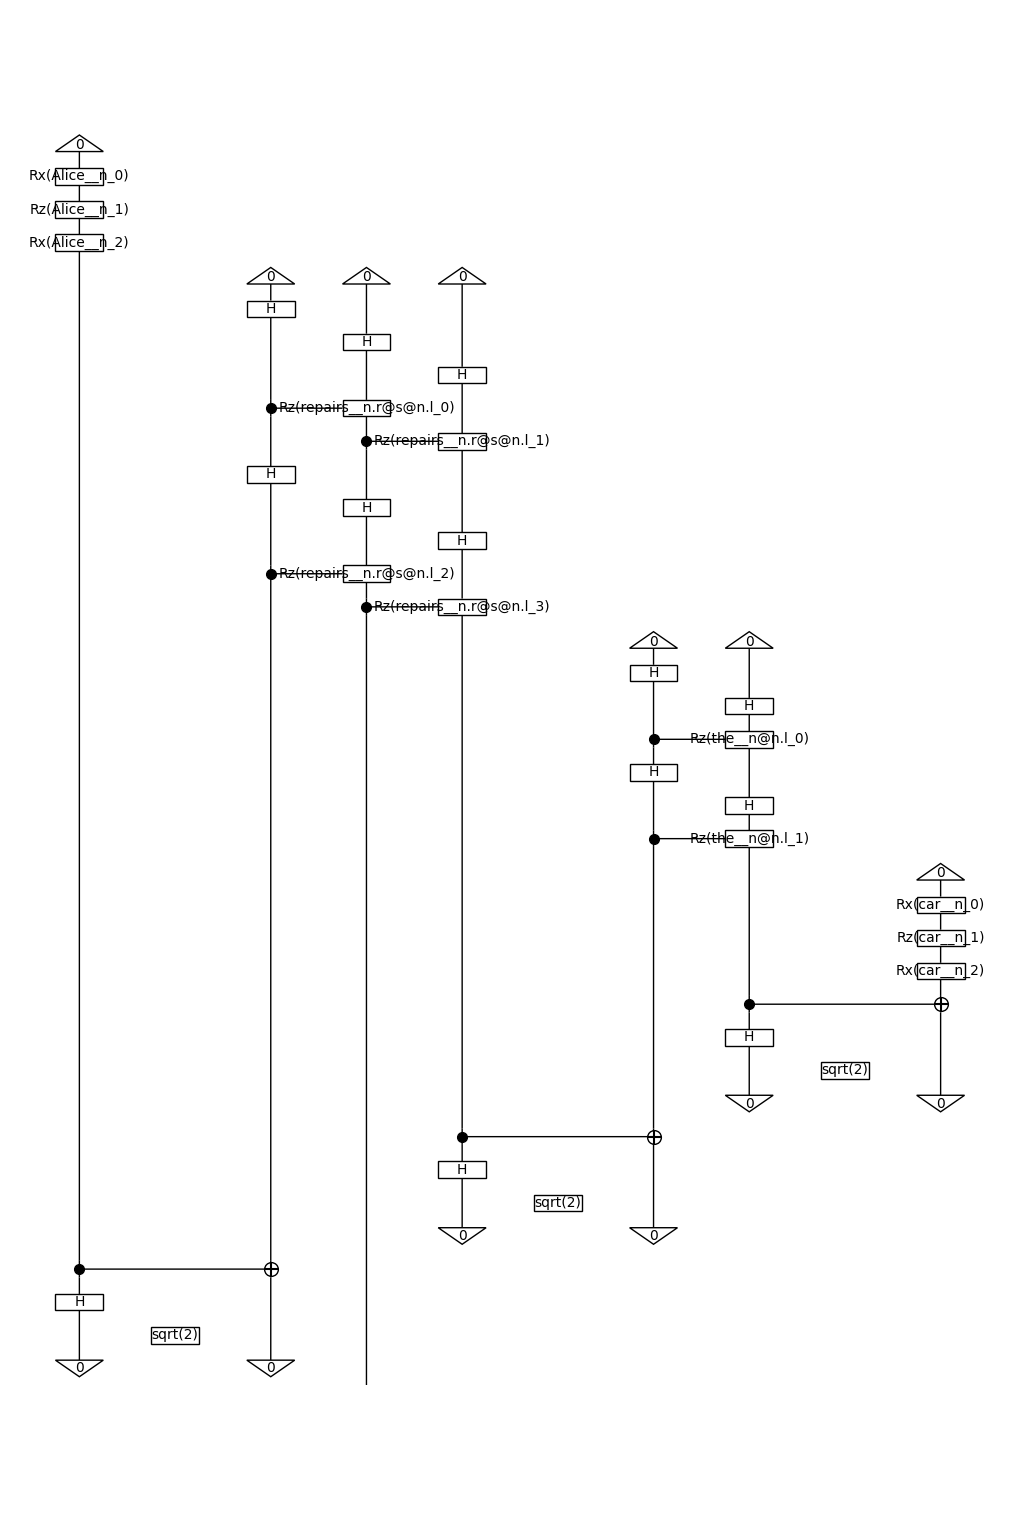

In [10]:
discopy_circuit.draw(figsize=(10, 15))

In [11]:
tket_circuit = ansatz(diagram).to_tk()
render_circuit_jupyter(tket_circuit)

We can see how many parameters are needed for each word depending of the dimensionality assigned to N and S spaces, once the circuit has been rewritten. And it is also possible replacing the free parameters by values as it is done in the cell below.

In [12]:
from sympy import default_sort_key

parameters = sorted(tket_circuit.free_symbols(), key=default_sort_key)

param_dict = {p: i * 1 for i, p in enumerate(parameters)}
param_dict

{Alice__n_0: 0,
 Alice__n_1: 1,
 Alice__n_2: 2,
 car__n_0: 3,
 car__n_1: 4,
 car__n_2: 5,
 repairs__n.r@s@n.l_0: 6,
 repairs__n.r@s@n.l_1: 7,
 repairs__n.r@s@n.l_2: 8,
 repairs__n.r@s@n.l_3: 9,
 the__n@n.l_0: 10,
 the__n@n.l_1: 11}

## Dressed Quantum Circuits

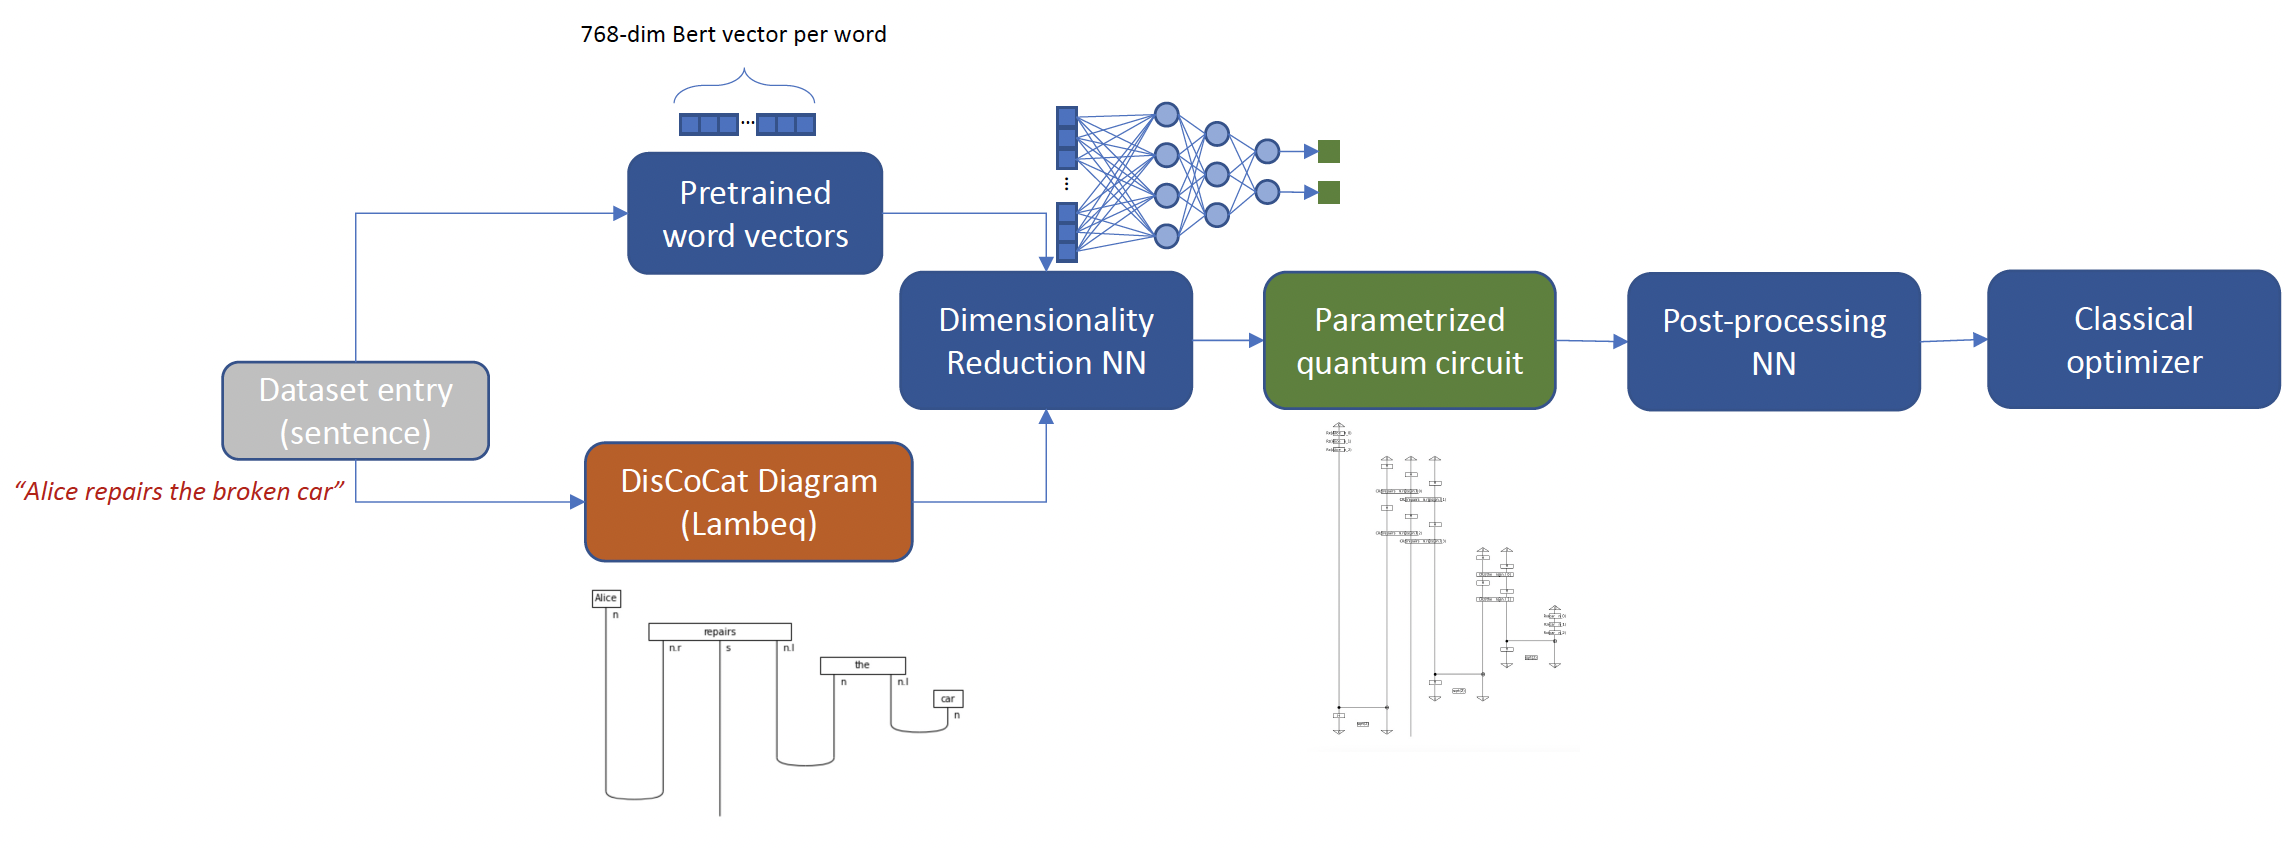

In [13]:
from IPython.display import Image
Image(filename='images/dressed diagram.png') 

In [14]:
import time

In [15]:
parser = BobcatParser()

In [52]:
class QSentence:
    
    def __init__(self, sentence_string, n_dim, s_dim, depth=1, label=None):
        self.label=label
        self.n = AtomicType.NOUN
        self.s = AtomicType.SENTENCE
        self.p = AtomicType.PREPOSITIONAL_PHRASE
        self.string = sentence_string
        
        tic = time.perf_counter()
        #self.parser = DepCCGParser()
        #self.parser = BobcatParser()
        self.diagram = parser.sentence2diagram(self.string)
        toc = time.perf_counter()
        print(f"Bobcat Parsed sentence in {toc - tic:0.4f} seconds")
        
        tic = time.perf_counter()
        self.ansatz = IQPAnsatz({self.n: 1, self.s: 1, self.p: 1}, n_layers=depth)
        toc = time.perf_counter()
        print(f"Generated IQPansatz in {toc - tic:0.4f} seconds")
        
        tic = time.perf_counter()
        self.discopy_circuit = self.ansatz(self.diagram)
        toc = time.perf_counter()
        print(f"Generated Discopy Circuit in {toc - tic:0.4f} seconds")
        
        tic = time.perf_counter()
        self.tk_circuit = self.discopy_circuit.to_tk()
        toc = time.perf_counter()
        print(f"Converted circuit to tket in {toc - tic:0.4f} seconds")
        
        tic = time.perf_counter()
        self.parameters = sorted(self.tk_circuit.free_symbols(), key=default_sort_key)
        toc = time.perf_counter()
        print(f"Sorted Parameters in {toc - tic:0.4f} seconds")
        
        tic = time.perf_counter()
        self.embeddings = self.get_sentence_BERT_embeddings()
        toc = time.perf_counter()
        print(f"Found BERT embeddings in {toc - tic:0.4f} seconds")
        print("SENTENCE COMPLETE_____________________________\n \n") 
        
    
        

    #def set_parameters(q_tensor_params):
        #parameters = sorted(tket_circuit.free_symbols(), key=default_sort_key)
        #param_dict = {p: i for i, p in zip(parameters, pre_out_params)}
        #param_dict
        
        
    
    def get_sentence_BERT_embeddings(self):
        SentenceList = self.string
        Sentences_Embeddings = []
        if type(SentenceList) == str:
            SentenceList = [SentenceList]
        for sentence in SentenceList:
            tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, tokenizer)
            list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
            nwords = len(sentence.split(" "))

            word_embeddings = []
            for word in sentence.split(" "):
                word_index = tokenized_text.index(word.lower().replace(".",""))
                word_embeddings.append(list_token_embeddings[word_index])

            Sentences_Embeddings.append(word_embeddings)
        return Sentences_Embeddings
        
        

    def GetNParamsWord(self):
        w=0
        params_per_word=[0]
        for i, param in enumerate(self.parameters):

            word = param.name.split("__")[0]
            if i==0:
                prev_word=word
            if word==prev_word:
                    params_per_word[w]+=1
            else:
                w+=1
                params_per_word.append(1)
                prev_word=word
        return params_per_word

    
    
class DiscoPyCircuit:
    
    def __init__(self, QSentence):
        self.circuit = QSentence.ansatz(QSentence.diagram)
        self.tket_circuit = self.circuit.to_tk()
        self.parameters = sorted(self.tket_circuit.free_symbols(), key=default_sort_key)
        
     
        

In [53]:
BertDim = 768
class DressedQuantumNet(nn.Module):
 #This class implements the pre processing neural network needed to reduce the dimensionality of BERT embeddings.
#A dimension for an intermediate representation, as well as the max and min numbers of parameters that are expected
#to appear in the circuits is also provided. A different number of layers will be applied depending of the 
#numbers of parameters needed to encode that word.

#When the circuit is run using pytket and AerBackend(), the tensor network nature of the parameters is lost, and all we
#is a classical bitstring and some probabilities. Alternative options like using differentiable Pennylane circuits 
#could solve this issue. An interface between Pennylane and tket exists and it is worth looking into it. 

    def __init__(self, Sentence):
        
        super().__init__()
        intermediate_dimension= 20
        max_param = 5
        min_param = 1
        self.Sentence = Sentence
        self.QNParamWords = Sentence.GetNParamsWord()
        self.pre_net = nn.Linear(BertDim, intermediate_dimension)
        self.pre_net_max_params = nn.Linear(intermediate_dimension, max_param)
        self.cascade_layers = []
        
        #CASCADE LAYERS: Consecutive layers reduce the number of parameters until getting the desired number
        #for that specific word
        
        for layer in range(max_param,min_param,-1):
            self.cascade_layers.append(nn.Linear(layer, layer-1))
            
            
    def forward(self):
        sentence_q_params = []
        for i, embedding in enumerate(self.Sentence.embeddings[0]):
            n_q_params = self.QNParamWords[i]
            pre_out = self.pre_net(torch.tensor(embedding))
            pre_out = self.pre_net_max_params(pre_out)
            for j, layer in enumerate(self.cascade_layers):
                layer_n_out = layer.out_features
                if n_q_params <= layer_n_out:
                    pre_out = self.cascade_layers[j](pre_out)
            q_in = torch.tanh(pre_out) * np.pi / 2.0  
            sentence_q_params.append(q_in)
        self.qparams = torch.cat(sentence_q_params)
        parameter_names = self.Sentence.tk_circuit.free_symbols()
        self.parameter_names = parameter_names
        param_dict = {p: q for p, q in zip(self.parameter_names, self.qparams)}
        MyCirc = self.Sentence.tk_circuit
        s_qubits = self.Measure_s_qubits(MyCirc)
        MyCirc.symbol_substitution(param_dict)
        backend = AerBackend()
        #backend.get_compiled_circuits([MyCirc])

        handle = backend.process_circuits(backend.get_compiled_circuits([MyCirc]), n_shots=2000)
        counts = backend.get_result(handle[0]).get_counts()
        result_dict = self.get_norm_circuit_output(counts, s_qubits)
        all_bitstrings = self.calculate_bitstring(s_qubits)
        for bitstring in all_bitstrings:
            if bitstring not in result_dict.keys():
                result_dict[bitstring] = 0
        return list(result_dict.values())
    

    
    
    
    def Measure_s_qubits(self, Circuit):
        #In the DisCoCat pytket circuits the sentence qubits are not measured, and thus additional measurements
        #need to be performed. Otherwise, we will get bitsrings shorter than the number of qubits of the circuits, 
        #corresponding only to the post selected ones.
        s_qubits=[]
        for qubit in Circuit.qubits:
            if qubit not in list(Circuit.qubit_readout.keys()):
                s_qubits.append(qubit.index[0])
        n_post_select = len(Circuit.bit_readout.keys())
        for i, s_qubit in enumerate(s_qubits):
            Circuit.add_bit(Bit("c", n_post_select+i))
        sen_c_regs = list(Circuit.bit_readout.keys())[n_post_select:]
        for i, qubit in enumerate(s_qubits):
            bit = list(Circuit.bit_readout.keys()).index(sen_c_regs[i])
            Circuit.Measure(qubit, bit)
        return sen_c_regs

    
    def satisfy_post_selection(self,post_selection, result):
        #This is used to tell if the output bitstrings satify the post selection conditions given by the ciruit.
        for index, value in enumerate(result):
            if index in post_selection:
                if value != post_selection[index]:
                    return False
        return True

    def list2bitstring(self,bitlist):
        bitstring=str()
        for i in bitlist:
            bitstring+=str(i)
        return bitstring

    def norm_probs(self,prob_result):
        tot = sum(list(prob_result.values()))
        for bitstring in prob_result.keys():
            prob_result[bitstring]/=tot
        return prob_result

    def get_norm_circuit_output(self, counts, s_qubits):
        prob_result=dict()
        for bits in probs_from_counts(counts).keys():
            post_selected = self.satisfy_post_selection(self.Sentence.tk_circuit.post_selection, bits)
            if post_selected==True:
                s_qubits_index = []
                for qubit in s_qubits:
                    s_qubits_index.append(qubit.index[0])
                bitlist = list( bits[i] for i in s_qubits_index)
                bitstring = self.list2bitstring(bitlist)
                prob_result[bitstring] = probs_from_counts(counts)[bits]
        return self.norm_probs(prob_result)
    

    def calculate_bitstring(self, s_qubits):
        import itertools
        n = len(s_qubits)
        lst = list(itertools.product([0, 1], repeat=n))
        all_bitstrings = []
        for element in lst:
            string = ""
            for bit in element:
                string+=str(bit)
            all_bitstrings.append(string)
        return all_bitstrings



## Sentence pipeline (WIP)

In [65]:
from pytket import Circuit, Qubit, Bit
from pytket.extensions.qiskit import AerBackend
from pytket.utils import probs_from_counts

In [66]:
Sentences = ["Alice repairs car", "The child that plays in the park knows that my mother is a teacher"]
Dataset = []
for sentence in Sentences:
    Dataset.append(QSentence(sentence, n_dim=1, s_dim=1, depth = 1,label=True)) 
entry=0
DressedNet = DressedQuantumNet(Dataset[entry])
#counts = DressedNet.forward()

Bobcat Parsed sentence in 0.1368 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0204 seconds
Converted circuit to tket in 0.0202 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0354 seconds
SENTENCE COMPLETE_____________________________
 

Bobcat Parsed sentence in 0.2610 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.1042 seconds
Converted circuit to tket in 0.1036 seconds
Sorted Parameters in 0.0003 seconds
Found BERT embeddings in 0.0464 seconds
SENTENCE COMPLETE_____________________________
 



The DisCoCat diagram for the sentence parsed by Lambeq


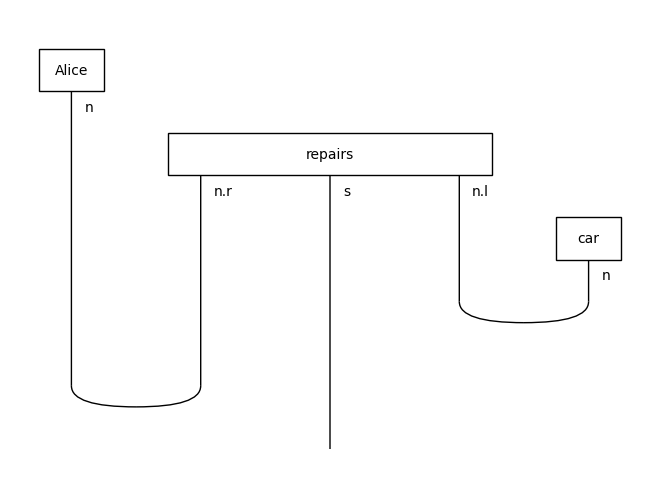

Now the diagram is rewritten as a circuit using the IQP Ansatz and tensor methods


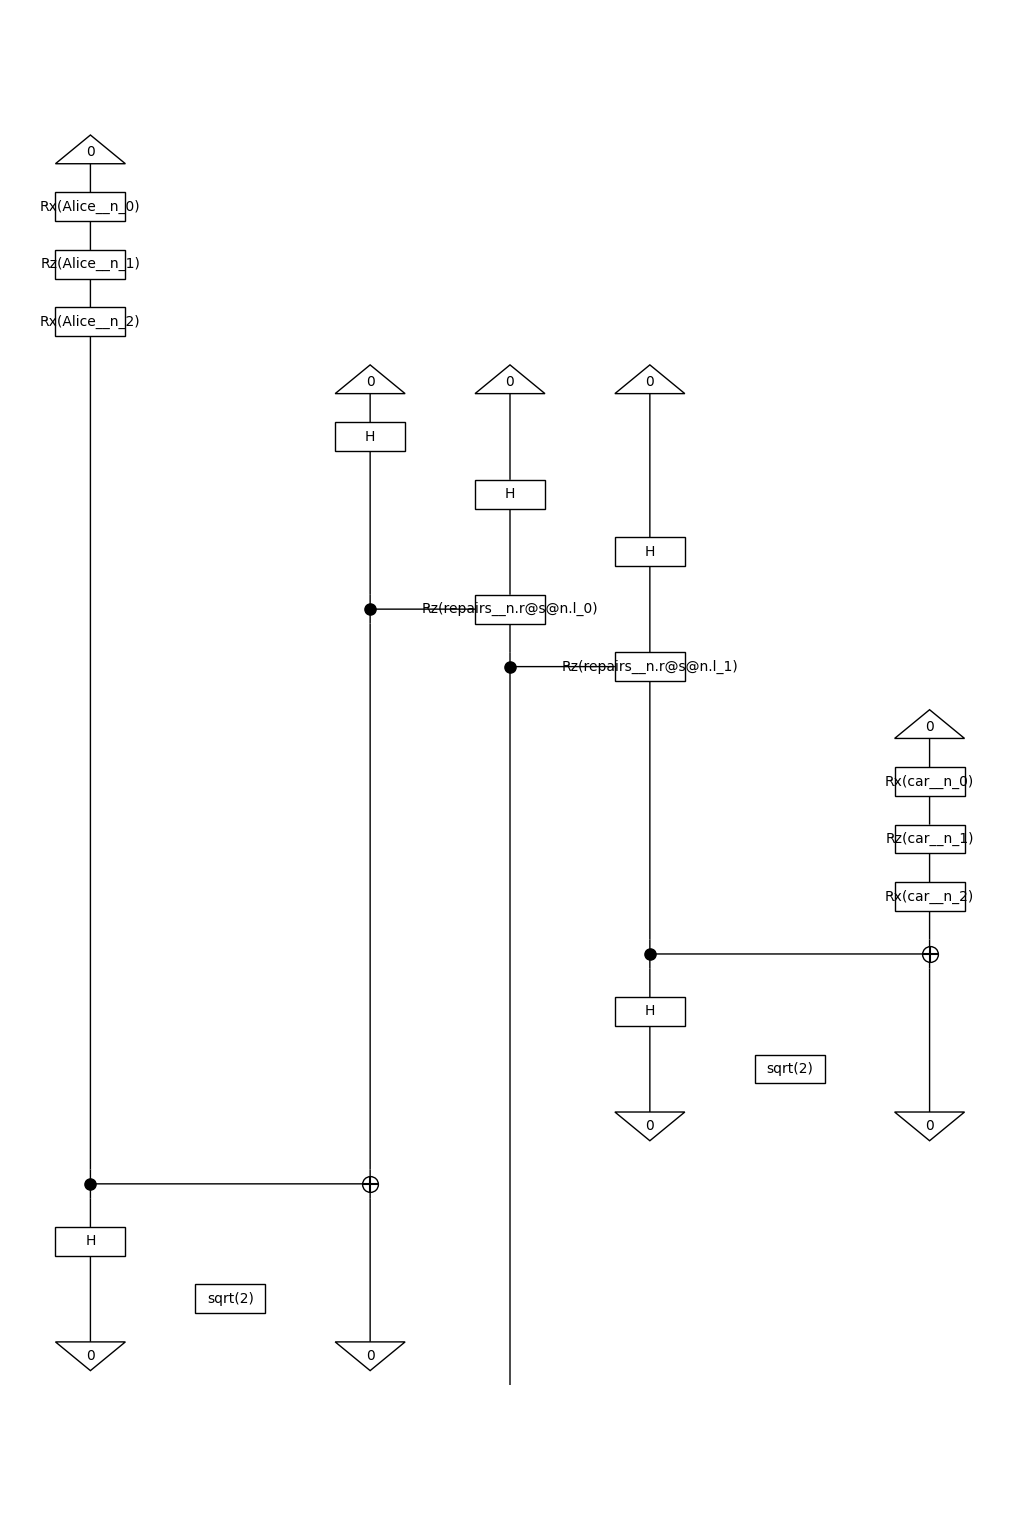


 Names of the parameters needed to encode the sentence in a DisCoCat circuit


AttributeError: 'DressedQuantumNet' object has no attribute 'parameter_names'

In [67]:
print("The DisCoCat diagram for the sentence parsed by Lambeq")
Dataset[entry].diagram.draw()

print("Now the diagram is rewritten as a circuit using the IQP Ansatz and tensor methods")
Dataset[entry].discopy_circuit.draw(figsize=(10, 15))

print("\n Names of the parameters needed to encode the sentence in a DisCoCat circuit")

for param in DressedNet.parameter_names:
    print(param)

print("\n Values of the parameters after reducing the dimensionaility of the BERT embeddings")
print(DressedNet.qparams)




After running the circuit and appliying the required post-processing, a binary output is obtained that can be used in a machine learning pipeline as a loss function given labeled sentences.

In [ ]:
print(counts)

The circuit can be displayed and now the parameters have been replaced by the values obtained using the preprocessing Neural Network. The gates are displayed as tridimensional rotations.

In [ ]:
render_circuit_jupyter(DressedNet.Sentence.tk_circuit)

More complex sentences can be parsed with Lambeq, solving the issue of being limited by the sentence structure. But, some ambiguity may exist for some sentences and this parser has to be investigated in more detail.

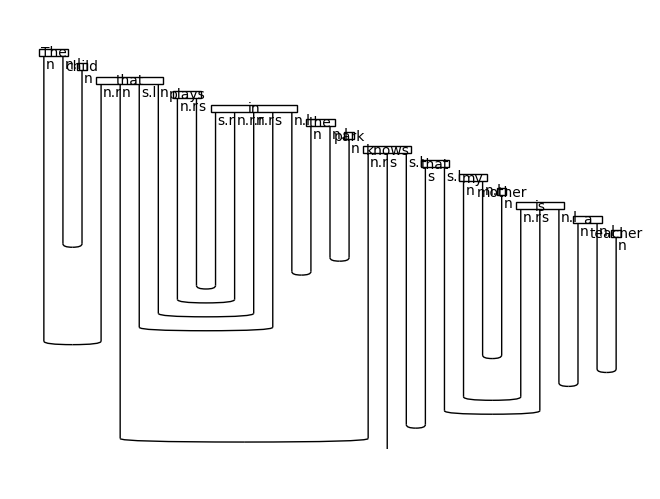

In [68]:
Dataset[1].diagram.draw()

## REFERENCES

### QML

PennyLane Transfer Learning(Transfer learning in hybrid classical-quantum neural networks)
https://arxiv.org/pdf/1912.08278.pdf

Quantum embeddings for machine learning
https://arxiv.org/pdf/2001.03622.pdf

Variational Quantum Circuit-Based Reinforcement Learning for
POMDP and Experimental Implementation
https://downloads.hindawi.com/journals/mpe/2021/3511029.pdf

QTN-VQC: AN END-TO-END LEARNING FRAMEWORK FOR
QUANTUM NEURAL NETWORKS
https://arxiv.org/pdf/2110.03861.pdf

Quantum activation functions for quantum neural networks
https://arxiv.org/pdf/2201.03700.pdf


Variational Quantum Reinforcement Learning via Evolutionary
Optimization
https://iopscience.iop.org/article/10.1088/2632-2153/ac4559/pdf

Quantum Neuron: an elementary building block for machine learning
on quantum computers
https://arxiv.org/pdf/1711.11240.pdf

Quantum recurrent neural networks:
https://arxiv.org/pdf/2006.14619.pdf

CLASSICAL-TO-QUANTUM TRANSFER LEARNING FOR SPOKEN COMMAND
RECOGNITION BASED ON QUANTUM NEURAL NETWORKS
https://arxiv.org/pdf/2110.08689.pdf

Faster Quantum Alternative to Softmax Selection in
Deep Learning and Deep Reinforcement Learning
QNLP
https://www.cs.utep.edu/vladik/2019/tr19-52b.pdf


### QNLP

Lambeq: An Efficient High-Level Python
Library for Quantum NLP
https://arxiv.org/pdf/2110.04236.pdf

Quantum Language Model with Entanglement
Embedding for Question Answering
https://arxiv.org/pdf/2008.09943.pdf

Natural Language Processing Meets Quantum Physics:
A Survey and Categorization
https://aclanthology.org/2021.emnlp-main.254.pdf

Explainable Natural Language Processing with
Matrix Product States
https://arxiv.org/pdf/2112.08628.pdf


# Training the model: WIP

In [69]:
import pandas as pd
import json
filename = "../../../data/Complete_dataset.json"
with open(filename) as f:
    data = json.load(f)
dftrain = pd.DataFrame(data['train_data'])
dftrain["truth_value"]= dftrain["truth_value"].map({True: [1,0], False: [0,1]})
dftest = pd.DataFrame(data['test_data'])
dftest["truth_value"]= dftest["truth_value"].map({True: [1,0], False: [0,1]})


Dataset = []
for sentence, label in zip(dftrain["sentence"], dftrain["truth_value"]):
    print("Sentence: ", sentence, "     label: ", label)
    Dataset.append(QSentence(sentence_string=sentence, n_dim=1, s_dim=1, depth = 1, label = label))

Sentence:  cat chases      label:  [1, 0]
Bobcat Parsed sentence in 0.1360 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0120 seconds
Converted circuit to tket in 0.0083 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0273 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  mouse meows      label:  [0, 1]
Bobcat Parsed sentence in 0.1178 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0060 seconds
Converted circuit to tket in 0.0065 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0251 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  chicken eats fox      label:  [0, 1]
Bobcat Parsed sentence in 0.1016 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0128 seconds
Converted circuit to tket in 0.0106 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0252 seconds
SENTENCE COMPLETE_____________________

Found BERT embeddings in 0.0273 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  seal runs      label:  [1, 0]
Bobcat Parsed sentence in 0.1100 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0062 seconds
Converted circuit to tket in 0.0055 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0240 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  mouse bites cheese      label:  [1, 0]
Bobcat Parsed sentence in 0.1115 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0148 seconds
Converted circuit to tket in 0.0119 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0280 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  cat meows      label:  [1, 0]
Bobcat Parsed sentence in 0.1119 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0077 seconds
Converted circuit to tket in 0.0080 seconds
Sorted Parameters in 0.00

Bobcat Parsed sentence in 0.1168 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0165 seconds
Converted circuit to tket in 0.0120 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0245 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  mouse squeaks      label:  [1, 0]
Bobcat Parsed sentence in 0.1069 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0065 seconds
Converted circuit to tket in 0.0064 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0294 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  cat runs in water      label:  [0, 1]
Bobcat Parsed sentence in 0.1228 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0228 seconds
Converted circuit to tket in 0.0198 seconds
Sorted Parameters in 0.0002 seconds
Found BERT embeddings in 0.0309 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  dog runs after c

Found BERT embeddings in 0.0285 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  mouse bites cheese      label:  [0, 1]
Bobcat Parsed sentence in 0.1403 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0190 seconds
Converted circuit to tket in 0.0131 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0413 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  fox eats chicken      label:  [1, 0]
Bobcat Parsed sentence in 0.1524 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0148 seconds
Converted circuit to tket in 0.0104 seconds
Sorted Parameters in 0.0001 seconds
Found BERT embeddings in 0.0296 seconds
SENTENCE COMPLETE_____________________________
 

Sentence:  dog bites fox      label:  [1, 0]
Bobcat Parsed sentence in 0.1201 seconds
Generated IQPansatz in 0.0001 seconds
Generated Discopy Circuit in 0.0211 seconds
Converted circuit to tket in 0.0187 seconds
Sorted Paramet

In [70]:
import torch.optim as optim
print(DressedNet.parameters())

criterion = nn.BCELoss()
optimizer = optim.SGD(DressedNet.parameters(), lr=0.001, momentum=0.9)

<generator object Module.parameters at 0x17da6fd80>


In [47]:
import torch.optim as optim
DressedNet2 = DressedQuantumNet(Dataset[0])

print(DressedNet2.parameters())


criterion = nn.BCELoss()
optimizer = optim.SGD(DressedNet2.parameters(), lr=0.001, momentum=0.9)

<generator object Module.parameters at 0x17fceb450>


In [71]:
DressedNet2 = DressedQuantumNet(Dataset[0])
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for count,sentence in enumerate(Dataset):
        label = sentence.label
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        net = DressedQuantumNet(sentence)
        outputs = torch.Tensor(net.forward())
        print("outputs = ", outputs)
        loss = criterion(input=outputs, target=torch.Tensor(label))
        loss = torch.autograd.Variable(loss, requires_grad = True)
        loss.backward()
        optimizer.step()
        del net

        # print statistics
        running_loss += loss.item()
        print("Count = ",count)
        print("Running Loss = ",running_loss/2000)
        #if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #running_loss = 0.0

print('Finished Training')
print(DressedNet.state_dict())

outputs =  tensor([0.4745, 0.5255])
Count =  0
Running Loss =  0.00037277370691299436
outputs =  tensor([0.4818, 0.5182])
Count =  1
Running Loss =  0.0007014882862567902
outputs =  tensor([0.4667, 0.5333])
Count =  2
Running Loss =  0.0010157926082611083
outputs =  tensor([0.9333, 0.0667])
Count =  3
Running Loss =  0.0023698177337646486
outputs =  tensor([0.5429, 0.4571])
Count =  4
Running Loss =  0.0026752722561359404
outputs =  tensor([1., 0.])
Count =  5
Running Loss =  0.0026752722561359404
outputs =  tensor([0.5000, 0.5000])
Count =  6
Running Loss =  0.0030218458473682402
outputs =  tensor([0.3924, 0.6076])
Count =  7
Running Loss =  0.003489576131105423
outputs =  tensor([0.3493, 0.6507])
Count =  8
Running Loss =  0.0037044409811496735
outputs =  tensor([1., 0.])
Count =  9
Running Loss =  0.053704440981149675
outputs =  tensor([0.9286, 0.0714])
Count =  10
Running Loss =  0.055023969560861585
outputs =  tensor([0.7895, 0.2105])
Count =  11
Running Loss =  0.0558030419051647

## Quantum in other NLP or ML architectures

In [ ]:
Image(filename='images/QNLP_arch.png') 

In Transformer architecture, Quantum Computing could be used:

* To replace feedforward layers with variational quantum circuits
* Cosine transform is a potential candidate to replace attention mechanism
* Fourier transform can be implemented efficiently in QC, and it could be used as positional embeddings
* Attention matrices could be replaced by trainable quantum operators* 

In [ ]:
Image(filename='images/Transformer.png') 

In [ ]:
Image(filename='images/Attention.png') 

The formula above calculates Attention given a Query matrix Q, a Keys matrix K and a values matrix V. This allows to emphasize relations between different part of a sequence in a corpus. A sensible idea is to replace these matrices by quantum operators and apply them after a sentence has been encoded in a quantum circuit using the DisCoCat model.